# GLAUCOMA DETECTION

In [51]:
# Descomentar para instalar librerias

# !pip install --upgrade --force-reinstall --no-deps kaggle

# # Uninstall tensorflow first
# !pip uninstall tensorflow -y

# # Install tensorflow-gpu (stable version)
# !pip install tensorflow-gpu  # stable

# # !pip install pandas
# # !pip install numpy
# # !pip install seaborn
# # !pip install matplotlib
# # !pip install cv2
# # !pip install keras
# # !pip install sklearn
# !pip install sinfo

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers.experimental.preprocessing import RandomContrast, RandomFlip, RandomRotation
from keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPool2D
from keras.optimizers import Adam, SGD
from keras.applications import VGG16, VGG19, ResNet50, ResNet50V2
from sklearn.utils import compute_class_weight
from keras.callbacks import LearningRateScheduler
import pickle
from sinfo import sinfo
import zipfile
import os
from google.colab import drive

%matplotlib inline
style.use('fivethirtyeight')

import warnings
warnings.filterwarnings("ignore")

In [3]:
sinfo()

-----
cv2         4.1.2
google      NA
matplotlib  3.2.2
numpy       1.19.5
pandas      1.1.5
seaborn     0.11.1
sinfo       0.3.1
sklearn     0.22.2.post1
tensorflow  2.4.1
-----
IPython             5.5.0
jupyter_client      5.3.5
jupyter_core        4.7.1
notebook            5.3.1
-----
Python 3.7.10 (default, Feb 20 2021, 21:17:23) [GCC 7.5.0]
Linux-4.19.112+-x86_64-with-Ubuntu-18.04-bionic
2 logical CPU cores, x86_64
-----
Session information updated at 2021-04-12 21:06


In [5]:
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/Proyectos DS/"

In [7]:
!kaggle datasets download -d sshikamaru/glaucoma-detection

 95% 178M/188M [00:00<00:00, 234MB/s]
100% 188M/188M [00:00<00:00, 251MB/s]


In [8]:
# Extract from archive
with zipfile.ZipFile('/content/glaucoma-detection.zip' ,'r') as zip_ref:
    zip_ref.extractall('./data')

In [9]:
!rm /content/glaucoma-detection.zip
!rm -rf /content/sample_data

---------------------

In [10]:
dir_train_img = '/content/data/Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Train'
dir_val_img = '/content/data/Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Validation'
dir_csv = '/content/data/glaucoma.csv'

---------------------------------

In [11]:
glaucoma = pd.read_csv(dir_csv)
glaucoma

,Filename,ExpCDR,Eye,Set,Glaucoma
0,001.jpg,0.7097,OD,A,0
1,002.jpg,0.6953,OS,A,0
2,003.jpg,0.9629,OS,A,0
3,004.jpg,0.7246,OD,A,0
4,005.jpg,0.6138,OS,A,0
...,...,...,...,...,...
645,646.jpg,0.6560,OD,A,1
646,647.jpg,0.7365,OD,A,1
647,648.jpg,0.5101,OS,A,1
648,649.jpg,0.5227,OD,B,0


Descripcion del dataset

*   Filename: Nombre o numero de la imagen. 

*   ExpCDR: cup-to-disc ratio. La relación copa / disco (a menudo anotada como CDR) es una medida utilizada en oftalmología y optometría para evaluar la progresión del glaucoma.

*   Eye: Indica cual ojo es evaluado. Ojo derecho (OD) o ojo izquierdo (OS).

*   Glaucoma: 1 para positivo y 0 para negativo.



In [12]:
glaucoma.columns

Index(['Filename', 'ExpCDR', 'Eye', 'Set', 'Glaucoma'], dtype='object')

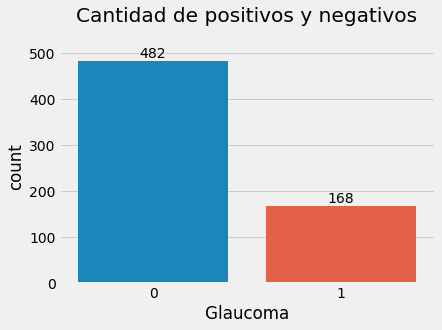

In [13]:
ax = sns.countplot(glaucoma.Glaucoma)
plt.title('Cantidad de positivos y negativos\n')
plt.xticks()

for rect in ax.patches:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2., 1*height,'%d' % int(height),ha='center', va='bottom');

Se puede observar que nuestro dataset se encuentra desbalanceado. Hay 482 registros en los que no hay presencia de glaucoma, mientras que si lo hay para 168 registros

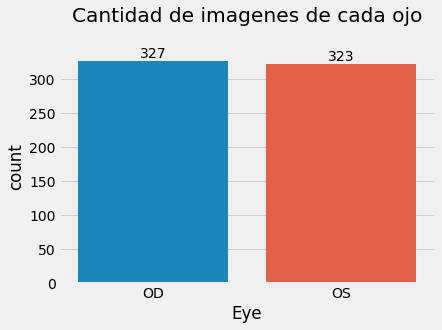

In [14]:
ax = sns.countplot(glaucoma.Eye)
plt.title('Cantidad de imagenes de cada ojo\n')
plt.xticks()

for rect in ax.patches:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2., 1*height,'%d' % int(height),ha='center', va='bottom');

Existen en nuestro dataset 327 registros para el ojo derecho y 323 para el ojo izquierdo

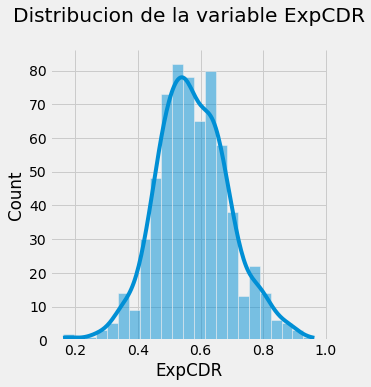

In [15]:
sns.displot(glaucoma.ExpCDR, kde=True).set(title='Distribucion de la variable ExpCDR\n');

Vemos que los valores entre 0.5 y 0.7 de CDR (Relacion copa/disco), son los que tienen mayor frecuencia en nuestro dataset

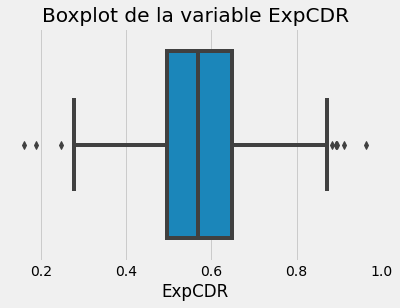

In [16]:
plt.title('Boxplot de la variable ExpCDR')
sns.boxplot(glaucoma.ExpCDR);

Aquellos valores de CDR menores a 0.25 o mayores a 0.85 pueden considerarse como outliers o valores atipicos

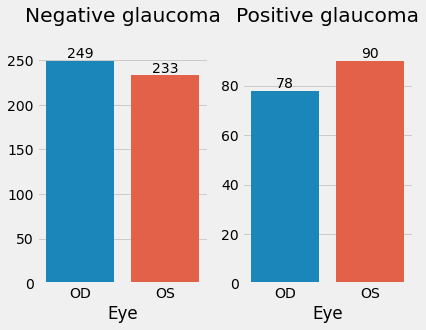

In [17]:
f, axes = plt.subplots(1, 2)

ax=sns.countplot(glaucoma[glaucoma.Glaucoma == 0].Eye, ax=axes[0])
ax.title.set_text('Negative glaucoma\n')
ax.set_ylabel('')
ax1=sns.countplot(glaucoma[glaucoma.Glaucoma == 1].Eye, ax=axes[1])
ax1.title.set_text('Positive glaucoma\n')
ax1.set_ylabel('')

for rect in ax.patches:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2., 1*height,'%d' % int(height),ha='center', va='bottom');
    
for rect in ax1.patches:
    height = rect.get_height()
    ax1.text(rect.get_x() + rect.get_width()/2., 1*height,'%d' % int(height),ha='center', va='bottom');

Podemos ver la cantidad de registros que hay para cada ojo y, a su vez, la cantidad que son negativos o positivos para glaucoma

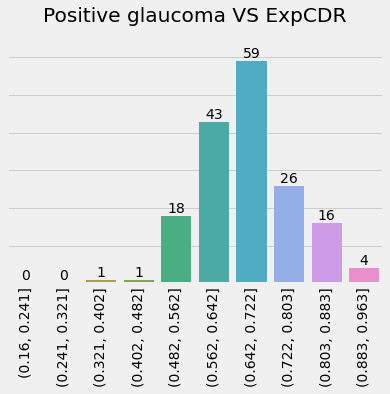

In [18]:
glaucoma.CDR_cuts = pd.cut(glaucoma["ExpCDR"], 10)   
group1 = glaucoma.groupby(glaucoma.CDR_cuts)

ax = sns.barplot(x=list(group1.groups), y= group1.Glaucoma.sum())
plt.xticks(rotation=90)
ax.set_ylabel('')
ax.set_yticklabels([])
ax.title.set_text('Positive glaucoma VS ExpCDR\n')

for rect in ax.patches:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2., 1*height,'%d' % int(height),ha='center', va='bottom');

Podemos ver que los glaucoma positivos se distribuyen mayoritariamente para una ExpCDR (relacion copa/disco) entre 0.5 y 0.8

--------

In [19]:
list(os.listdir(dir_train_img))

['Glaucoma_Negative', 'Glaucoma_Positive']

In [20]:
list(os.listdir(dir_val_img))

['Glaucoma_Negative', 'Glaucoma_Positive']

In [21]:
pos_train = dir_train_img + '/Glaucoma_Positive'
neg_train = dir_train_img + '/Glaucoma_Negative'

In [22]:
print(len(os.listdir(pos_train)))
print(len(os.listdir(neg_train)))

134
386


In [23]:
pos_val = dir_val_img + '/Glaucoma_Positive'
neg_val = dir_val_img + '/Glaucoma_Negative'

In [24]:
print(len(os.listdir(pos_val)))
print(len(os.listdir(neg_val)))

34
96


(2048, 3072, 3) 



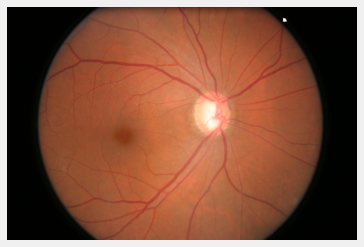

In [25]:
img = cv2.imread(pos_train + '/050.jpg')
img = img[:,:,[2,1,0]]
plt.axis('off')
plt.imshow(img);
print(img.shape,'\n')

In [26]:
img.min(), img.max(), img.mean()

(0, 255, 75.34807247585721)

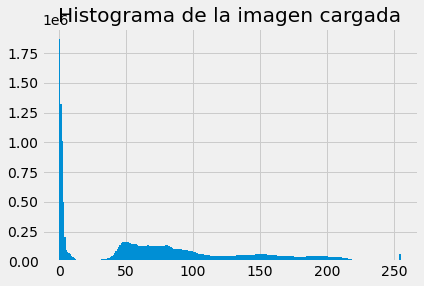

In [27]:
plt.title('Histograma de la imagen cargada')
plt.hist(img.ravel(),255,[0,255]);
plt.show();

Podemos ver por el histograma de la imagen, que hay en ella una mayor presencia de colores oscuros

In [28]:
image_input_shape = (224,224)

datagen_train = ImageDataGenerator(validation_split=0.2,    #Creating batches and data augmentation
                                   rescale=1./255,
                                   horizontal_flip=True,
                                   shear_range=0.2,
                                   rotation_range=10,
                                   brightness_range=[1.0, 1.2]
                                   )

train_batches = datagen_train.flow_from_directory(
    dir_train_img,
    target_size=image_input_shape,
    shuffle=True,
    batch_size=32,
    class_mode='binary',
    subset='training',
    seed=42 
    )

val_batches = datagen_train.flow_from_directory(
    dir_train_img,
    target_size=image_input_shape,
    shuffle=True,
    batch_size=32,
    class_mode='binary',
    subset='validation',
    seed=42
)

datagen_test = ImageDataGenerator(rescale=1./255)

test_batches = datagen_test.flow_from_directory(
    dir_val_img,
    target_size=image_input_shape,
    shuffle=False,
    class_mode='binary',
)

Found 417 images belonging to 2 classes.
Found 103 images belonging to 2 classes.
Found 130 images belonging to 2 classes.


In [29]:
train_batches.class_indices

{'Glaucoma_Negative': 0, 'Glaucoma_Positive': 1}

In [30]:
val_batches.class_indices

{'Glaucoma_Negative': 0, 'Glaucoma_Positive': 1}

In [31]:
test_batches.class_indices

{'Glaucoma_Negative': 0, 'Glaucoma_Positive': 1}

In [32]:
images, labels = next(train_batches) #Next output of image generator

print(images.shape, f"{images.shape[0]} shape of images {images.shape[1]}x{images.shape[2]}x{images.shape[3]}")
print(labels.shape, f"{labels.shape[0]} labels.")

(32, 224, 224, 3) 32 shape of images 224x224x3
(32,) 32 labels.


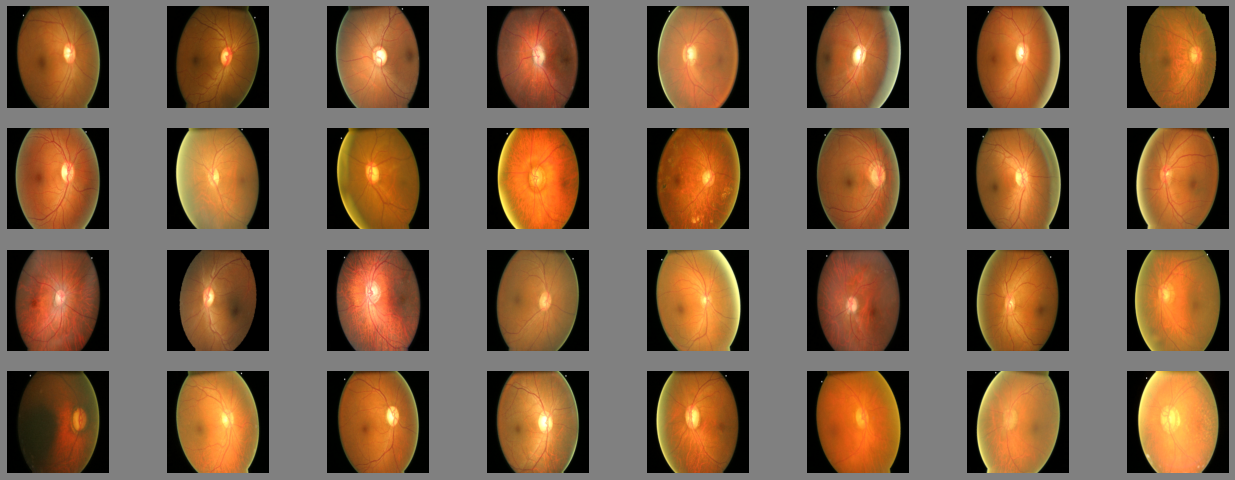

In [33]:
fig=plt.figure(figsize=(20,8), facecolor='gray')

for i in range(1,33):
    img = images[i-1]
    fig.add_subplot(4, 8, i)
    plt.imshow(img)
    plt.axis('off')
plt.show()

Vemos el batch de imagenes generadas

In [34]:
# # Data augmentation
# data_augmentation = Sequential([RandomContrast(0.1),
#                                 RandomFlip('horizontal'),
#                                 RandomRotation(0.2)])

In [35]:
#Balanced classes
classWeight = compute_class_weight('balanced', np.unique(train_batches.classes), train_batches.classes) 
classWeight = dict(enumerate(classWeight))

In [36]:
model = Sequential()

#model.add(data_augmentation)

conv_base = VGG16(weights="imagenet", include_top=False,
                  input_shape=(224,224,3))
conv_base.trainable = False

model.add(conv_base)
model.add(Flatten())
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(1, activation="sigmoid"))

58892288/58889256 [==============================] - 0s 0us/step


In [37]:
opt = Adam()

In [38]:
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy']) 

In [39]:
def scheduler(epoch, lr):
  if epoch < 10:
    return lr * tf.math.exp(0.1)
  else:
    return lr * tf.math.exp(-0.1)

callback = LearningRateScheduler(schedule=scheduler)

In [40]:
history = model.fit_generator(
          train_batches, # Training data
          steps_per_epoch=(417//32),
          epochs=20, 
          validation_data=val_batches, # Validation data
          validation_steps=(103//32),
          class_weight=classWeight,
          callbacks=[callback])

Epoch 1/20
13/13 [==============================] - 76s 3s/step - loss: 2.9047 - accuracy: 0.4595 - val_loss: 0.9340 - val_accuracy: 0.7500
Epoch 2/20
13/13 [==============================] - 40s 3s/step - loss: 2.4525 - accuracy: 0.5727 - val_loss: 0.5475 - val_accuracy: 0.7396
Epoch 3/20
13/13 [==============================] - 40s 3s/step - loss: 1.5641 - accuracy: 0.5881 - val_loss: 1.7149 - val_accuracy: 0.2500
Epoch 4/20
13/13 [==============================] - 40s 3s/step - loss: 1.3774 - accuracy: 0.4501 - val_loss: 0.9866 - val_accuracy: 0.2604
Epoch 5/20
13/13 [==============================] - 40s 3s/step - loss: 2.0028 - accuracy: 0.4810 - val_loss: 0.7573 - val_accuracy: 0.3021
Epoch 6/20
13/13 [==============================] - 39s 3s/step - loss: 1.3436 - accuracy: 0.4976 - val_loss: 0.8623 - val_accuracy: 0.2708
Epoch 7/20
13/13 [==============================] - 40s 3s/step - loss: 1.0064 - accuracy: 0.5230 - val_loss: 0.6669 - val_accuracy: 0.6042
Epoch 8/20
13/13 [==

In [41]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               12845568  
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1

In [42]:
test_results = model.evaluate(test_batches)
print(f'Test results - Loss: {test_results[0]} - Accuracy: {100*test_results[1]}%')

5/5 [==============================] - 9s 2s/step - loss: 0.6859 - accuracy: 0.7385
Test results - Loss: 0.6858618855476379 - Accuracy: 73.84615540504456%


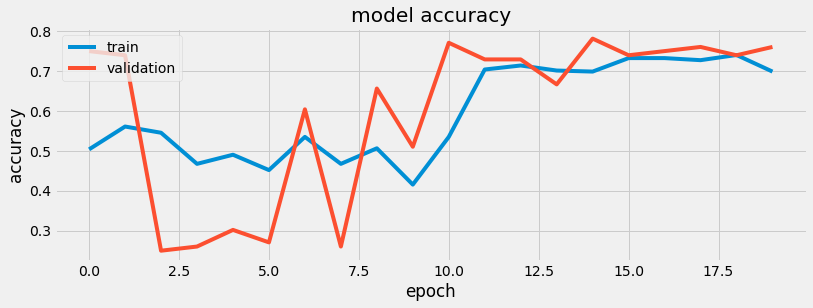

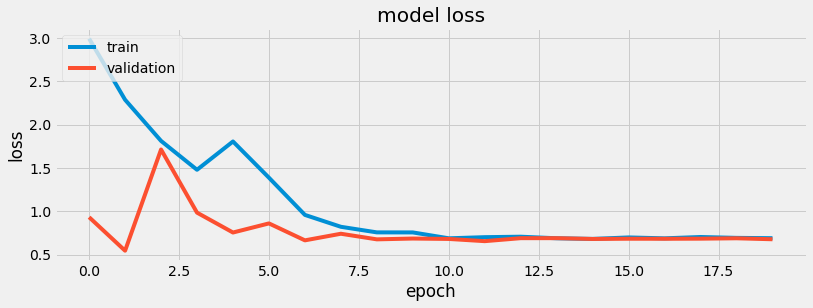

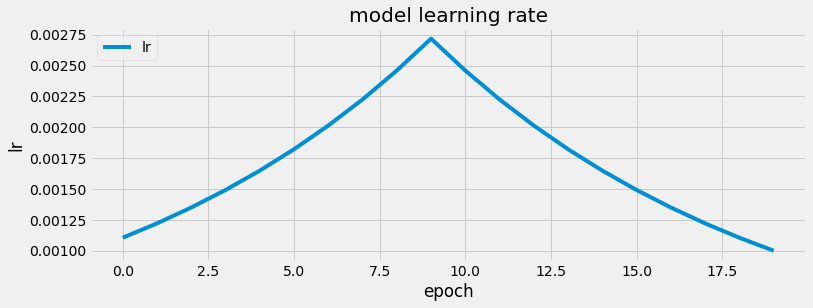

In [50]:
plt.figure(figsize=(12,4))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.figure(figsize=(12,4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.figure(figsize=(11.43,4))
plt.plot(history.history['lr'])
plt.title('model learning rate')
plt.ylabel('lr')
plt.xlabel('epoch')
plt.legend(['lr'], loc='upper left')
plt.show()

In [44]:
# #Tomamos un batch de imagenes de test
# imagenes_batch, etiquetas_batch = next(test_batches)
# predicciones = model.predict(imagenes_batch).flatten()
# predicciones_binarias = tf.where(predicciones < 0.5, 0, 1)

In [45]:
# plt.figure(figsize=(10, 20))
# for i in range(16):
#   ax = plt.subplot(8, 2, i + 1)
#   plt.imshow(imagenes_batch[i].astype("uint8"))
#   plt.title(f"Etiqueta: {test_batches[predicciones_binarias[i,]]}. Prediccion: {test_batches[predicciones_binarias[i]]}")
#   plt.axis("off")

### Trabajos futuros:
> Conseguir mas datos, utilizar otros parametros para el data augmentation, probar nuevas arquitecturas, variar de otra manera el learning rate, variar el optimizador y utilizar tecnicas de regularizacion


